In [4]:
#  Install Hugging Face Transformers
!pip install transformers

In [5]:
# Imports
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv("/content/drive/MyDrive/fullstack-imbalanced-dataset.csv")
df

,Unnamed: 0,review_text,Rating,Summary,review_length
0,0,its pricey ill admit it but its priced for con...,4,very nice snack for on the go,73
1,1,im a lowcarb lifer who also is a certified cho...,3,please stop calling this great chocolate,224
2,2,first of all its important to be aware that 16...,2,milka more watery than milky,38
3,3,locally i was only able to find cardamon at ab...,4,great product affordable too,48
4,4,it was smaller than i expected after getting t...,4,blue gel paste,20
...,...,...,...,...,...
125896,125896,did you know that if you wake up in the middle...,5,miracle salt is what it should be called,128
125897,125897,i was happy to find the different sized packag...,5,hard to find zours,95
125898,125898,i have celiac disease and been on a gf diet fo...,1,stomach upset,54
125899,125899,while the lentil seeds sprouted just fine i en...,2,packaging leaves much to be desired,42


In [8]:
df.columns


Index(['Unnamed: 0', 'review_text', 'Rating', 'Summary', 'review_length'], dtype='object')

In [9]:
df["Summary"] = df["Summary"].fillna("").replace("", "[NOSUMMARY]")


In [10]:
# Combine review + summary
df["combined_text"] = df["review_text"] + " " + df["Summary"]

In [11]:
#  Adjust Ratings (make 0-based for BERT)

df["Rating"] = df["Rating"] - 1  # If ratings are 1-5, they become 0-4


In [12]:
#. Train-Test-Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["combined_text"].tolist(),
    df["Rating"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["Rating"]
)

In [13]:
#  Tokenize
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_len = 200


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
print(len(train_texts), len(train_labels))
print(len(val_texts), len(val_labels))

100720 100720
25181 25181


In [15]:

train_encodings = tokenizer(train_texts, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")


In [16]:
# 7. Create Dataset Class
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }



In [17]:
train_dataset = ReviewDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = ReviewDataset(val_texts, val_labels, tokenizer, max_len)

In [18]:
# 8. Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [19]:

# 9. Load BERT Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
model = model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:

#  Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3  # 3 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)
loss_fn = torch.nn.CrossEntropyLoss()


In [21]:
# 11. Training Loop

epochs = 3
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")



Epoch 1 Training: 100%|██████████| 6295/6295 [58:02<00:00,  1.81it/s]


Epoch 1 Train Loss: 0.9285


Epoch 2 Training: 100%|██████████| 6295/6295 [58:10<00:00,  1.80it/s]


Epoch 2 Train Loss: 0.7539


Epoch 3 Training: 100%|██████████| 6295/6295 [58:08<00:00,  1.80it/s]

Epoch 3 Train Loss: 0.6111


In [24]:
# Save Model
model.save_pretrained("/content/drive/MyDrive/bert_review_model")
tokenizer.save_pretrained("/content/drive/MyDrive/bert_tokenizer_model")

('/content/drive/MyDrive/bert_tokenizer_model/tokenizer_config.json',
 '/content/drive/MyDrive/bert_tokenizer_model/special_tokens_map.json',
 '/content/drive/MyDrive/bert_tokenizer_model/vocab.txt',
 '/content/drive/MyDrive/bert_tokenizer_model/added_tokens.json')

In [25]:
# Set model to evaluation mode
model.eval()

train_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_train_loss = train_loss / len(train_loader)
train_accuracy = correct / total

print(f"Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")


Training Loss: 0.4795 | Training Accuracy: 0.8147


In [26]:
# Validation
model.eval()
total_val_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_val_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_val_loss = total_val_loss / len(val_loader)
accuracy = correct / total
print(f"Epoch {epoch+1} Val Loss: {avg_val_loss:.4f} | Val Accuracy: {accuracy:.4f}")


Epoch 3 Validation: 100%|██████████| 1574/1574 [05:21<00:00,  4.89it/s]

Epoch 3 Val Loss: 0.8981 | Val Accuracy: 0.6358


In [27]:
# 13. Prediction Function

def predict_rating(summary, review):
    text = summary + " " + review
    enc = tokenizer(text, truncation=True, padding="max_length", max_length=200, return_tensors="pt").to(device)
    model.eval()
    with torch.no_grad():
        output = model(**enc)
        pred_label = torch.argmax(output.logits, dim=1).item()
    return pred_label + 1  # Shift back to 1-5 scale


In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


Epoch 3 Validation: 100%|██████████| 1574/1574 [05:21<00:00,  4.90it/s]


In [30]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=3))


Classification Report:
              precision    recall  f1-score   support

           0      0.685     0.612     0.646      2520
           1      0.549     0.541     0.545      4142
           2      0.580     0.606     0.593      5927
           3      0.662     0.670     0.666      7555
           4      0.714     0.709     0.711      5037

    accuracy                          0.636     25181
   macro avg      0.638     0.628     0.632     25181
weighted avg      0.637     0.636     0.636     25181



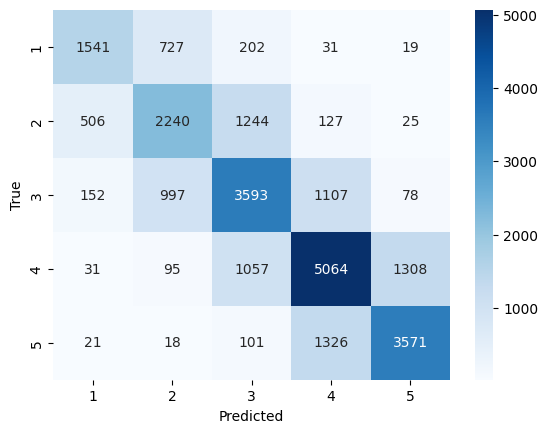

In [31]:
cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2,3,4])  # adjust if your labels are 1–5
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
